In [1]:
# !pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

2.0.0


# Data Pipelining and Estimator API

- The tf.data module is a high-level API that allows you to define high-efficiency input pipelines without worrying about threads, queues, synchronization, and distributed filesystems. The API was designed with simplicity in mind to overcome the usability issues of the previous low-level API.

- The tf.estimator API was designed to simplify and standardize machine learning programming, allowing to train, evaluate, run inference, and export for serving a parametric model, letting the user focus on the model and input definition only.

- The tf.data and tf.estimator APIs are fully compatible, and it is highly encouraged to use them together. Moreover, as we will see in the next sections, every Keras model, the whole eager execution, and even AutoGraph are fully compatible with the tf.data.Dataset object. 

However, the way of feeding the input shown so far is, in fact, hugely inefficient and error-prone, for the following reasons:

- The complete dataset can weight several thousands of GBs: no single standard computer or even a deep learning workstation has the memory required to load huge datasets in memory.

- Manually creating the input batches means taking care of the slicing indexes manually; errors can happen.

- Doing data augmentation, applying random perturbations to each input sample, slows down the model training phase since the augmentation process needs to complete before feeding the data to the model. Parallelizing these operations means you worry about synchronization problems among threads and many other common issues related to parallel computing. Moreover, the boilerplate code increases.
- Feeding a model whose parameters are on a GPU/TPU from the main Python process that resides on the CPU involves loading/unloading data, and this is a process that can make the computation suboptimal: the hardware utilization can be below 100% and is a complete waste.

# Setting up Data Pipeline

- Defining a training input pipeline is a standard process; the steps to follow can be framed as an Extract Transform and Load (ETL) process: that is, the procedure of copying the data from a data source to a destination system that will use it.

The ETL process consists of the following three steps that the tf.data.Dataset object allows us to

1. Extract: Read the data from the data source. It can be either local (persistent storage, already loaded in memory) or remote (cloud storage, remote filesystem).
2. Transform: Apply transformations to the data to clean, augment (random crop image, flip, color distortion, add noise), make it interpretable by the model. Conclude the transformation by shuffling and batching the data.
3. Load: Load the transformed data into the device that better fits the training needs (GPUs or TPUs) and execute the training.

- These ETL steps can be performed not only during the training phases but also during the inference.



# tf.data.Dataset object

- A tf.data.Dataset object represents an input pipeline as a collection of elements accompanied by an ordered set of transformations that act on those elements.

- Each element contains one or more tf.Tensor objects. For example, for an image classification problem, the tf.data.Dataset elements might be single training examples with a pair of tensors representing the image and its associated label.

The tf.data.Dataset class offers many static methods to use to create a dataset easily:

- Tensors in memory: tf.data.Dataset.from_tensors or tf.data.Dataset.from_tensor_slices. In this case, the tensors can be NumPy arrays or tf.Tensor objects.

- From a Python generator: tf.data.Dataset.from_generator.
- From a list of files that matches a pattern: tf.data.Dataset.list_files.

Also, there are two specializations of the tf.data.Dataset object created for working with two commonly used file formats:
- tf.data.TFRecordDataset to work with the TFRecord files
- tf.data.TextLineDataset to work with text files, reading them line by line

- From version 2.0 onward, the tf.data.Dataset object is iterable, which means you can either enumerate its elements using a for loop or create a Python iterator using the iter keyword.

A dataset object is a very flexible data structure that allows creating a dataset not only of numbers or a tuple of numbers but of every Python data structure.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices({
    "a" : tf.random.uniform([4]),
    "b" : tf.random.uniform([4,100], maxval=100, dtype=tf.float32)
})

In [0]:
for value in dataset:
    print(value["a"])

tf.Tensor(0.34601486, shape=(), dtype=float32)
tf.Tensor(0.20837188, shape=(), dtype=float32)
tf.Tensor(0.5718986, shape=(), dtype=float32)
tf.Tensor(0.71634376, shape=(), dtype=float32)


In [0]:
def noise():
    while True:
        yield tf.random.uniform((100,))

dataset = tf.data.Dataset.from_generator(noise, (tf.float32))

In [0]:
# for iter in dataset:
#     print(iter)

Using method chaining, it is possible to create new dataset objects, transforming the one just built to get the data our machine learning model expects as input. For example, if we want to sum 10 to every component of the noise vector, shuffle the dataset content, and create batches of 32 vectors each, we can do so by calling just three methods:

- The map method is the most widely used method of the tf.data.Dataset object since it allows us to apply a function to every element of the input dataset, producing a new, transformed dataset.

- The shuffle method is used in every training pipeline since this transformation randomly shuffles the input dataset using a fixed-sized buffer; this means that the shuffled data first fetches the buffer_size element from its input, then shuffles them and produces the output.

- The batch method gathers the batch_size elements from its input and creates a batch as output. The only constraint of this transformation is that all elements of the batch must have the same shape.

- To train a model, it has to be fed with all the elements of the training set for multiple epochs. The tf.data.Dataset class offers the repeat(num_epochs) method to do this.

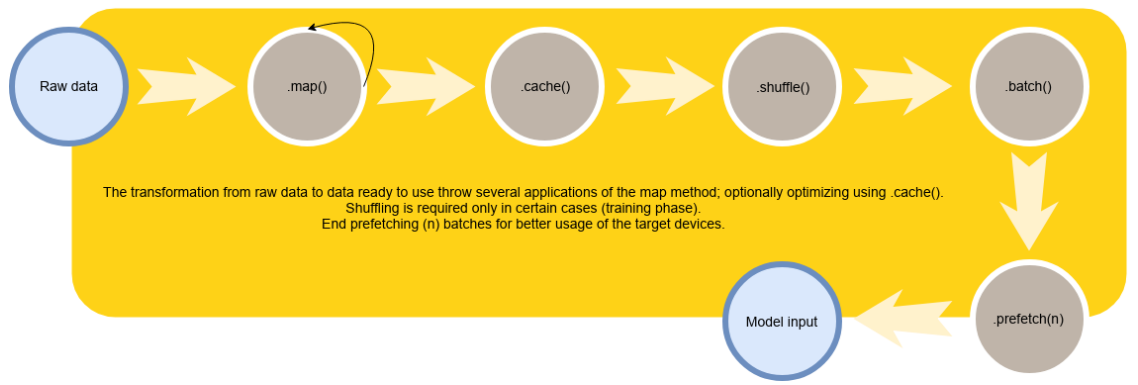

The diagram shows the typical data input pipeline: the transformation from raw data to data ready to be used by the model, just by chaining method calls. Prefetching and caching are optimization tips that are explained in the next section.

Please note that until not a single word has been said about the concept of thread, synchronization, or remote filesystems.

All this is hidden by the tf.data API:

Furthermore, tf.data.Dataset is high-level enough to make invisible all the threads execution and synchronization, but the automated solution can be suboptimal: the target device could be not completely used, and it is up to the user to remove the bottlenecks to reach the 100% usage of the target devices.

# Prefetching


- When the consumer is working, the producer shouldn't be idle but must work in the background to produce the data the consumer will need in the next iteration.

- The tf.data API offers the prefetch(n) method to apply a transformation that allows overlapping the work of the producer and the consumer. The best practice is adding prefetch(n) at the end of the input pipeline to overlap the transformation performed on the CPU with the computation done on the target.

- Choosing n is easy: n is the number of elements consumed by a training step, and since the vast majority of models are trained using batches of data, one batch per training step, then n=1.

# Cache elements


- The cache transformation can be used to cache the data in memory, completely removing the accesses to the data sources. This can bring huge benefits when using remote filesystems, or when the reading process is slow. Caching data after the first epoch is only possible if the data can fit into memory.

- The cache method acts as a barrier in the transformation pipeline: everything executed before the cache method is executed only once, thus placing this transformation in the pipeline can bring immense benefits. 

# Intro tf.Records

The TFRecord format is a binary and language-agnostic format (defined using protobuf) for storing a sequence of binary records. TensorFlow allows reading and writing TFRecord files that are composed of a series of tf.Example messages.

A tf.Example is a flexible message type that represents a {"key": value} mapping where key is the feature name, and value is its binary representation.

Where a row of the dataset (image, label, together with additional information) is serialized as an example and stored inside a TFRecord file, in particular, the image is not stored using a compression format but directly using its binary representation

This allows reading the image linearly, as a sequence of bytes, without the need to apply any image decoding algorithm on it, saving time (but using disk space).

Before the introduction of tfds (TensorFlow Datasets), reading and writing TFRecord files was a repetitive and tedious process since we had to take care of how to serialize and deserialize the input features to be compatible with the TFRecord binary format. TensorFlow Datasets, that is, a high-level API built over the TFRecord file specification, standardized the process of high-efficiency dataset creation, forcing the creation of the TFRecord representation of any dataset.

# Building a Dataset in tf.datasets

In [0]:
# import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

In [0]:
def train_dataset(batch_size=32, num_epochs=1):
    (train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
    input_x, input_y = train_x, train_y

    def scale_fn(image, label):
        return ((tf.image.convert_image_dtype(image, tf.float32) - 0.5) * 2.0, label)
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(input_x, -1), tf.expand_dims(input_y, -1))).map(scale_fn)

    dataset = dataset.cache().repeat(num_epochs)
    dataset = dataset.shuffle(batch_size)

    return dataset.batch(batch_size).prefetch(1)

# Data Augmentation

Data augmentation, instead, requires to apply meaningful transformation the raw data with the aim of creating a bigger dataset and train, thus, a model more robust to these kinds of variations.

Working with images, it is possible to use the whole API offered by the tf.image package to augment the dataset. The augmentation step consists in the definition of a function and its application to the training set, using the dataset map method.

The tf.image package already contains functions with stochastic behavior, designed for data augmentation. These functions apply the transformation to the input image with a 50% chance; this is the desired behavior since we want to feed the model with both original and augmented images. Thus, a function that applies meaningful transformations to the input data can be defined as follows:

In [0]:
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

In [0]:
def train_dataset(batch_size=32, num_epochs=1):
    (train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
    input_x, input_y = train_x, train_y

    def scale_fn(image, label):
        return ((tf.image.convert_image_dtype(image, tf.float32) - 0.5) * 2.0, label)
    
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, label
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(input_x, -1), tf.expand_dims(input_y, -1))).map(scale_fn)
    dataset.map(augment)

    dataset = dataset.cache().repeat(num_epochs)
    dataset = dataset.shuffle(batch_size)

    return dataset.batch(batch_size).prefetch(1)

- imgaug: https://github.com/aleju/imgaug
- albumentations: https://github.com/albu/albumentations
Using tf.py_function it is possible to execute Python code inside the map method, and thus use these libraries to generate a rich set of transformations (not offered by the tf.image package).

In [0]:
data_batch = train_dataset()

# TensorFlow Datasets – tfds  

TensorFlow Datasets is a collection of ready-to-use datasets that handle the downloading and preparation phases of the ETL process, constructing a tf.data.Dataset object.

TensorFlow Datasets (tfds) not only downloads and converts the dataset to a standard format but also locally converts the dataset to its TFRecord representation, making the reading from disk highly efficient and giving the user a tf.data.Dataset object that reads from TFRecord and is ready to use. The API comes with the concept of a builder. Every builder is an available dataset.

Different from the tf.data API, TensorFlow Datasets comes as a separate package that needs to be installed.

In [0]:
! pip install tensorflow-datasets

The package comes with two main methods: list_builders() and load():



- list_builders() returns the list of the available datasets.
- load(name, split) accepts the name of an available builder and the desired split. The split value depends on the builder since every builder carries its information.

In [0]:
import tensorflow_datasets as tfds

In [0]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'esnli', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imagenet_resized', 'imdb_reviews', 'iris'

In [0]:
ds_train, ds_test = tfds.load(name='mnist', split = ["train", "test"])

In a single line of code, we downloaded, processed, and converted the dataset to TFRecord, and created two tf.data.Dataset objects to read them.

In this single line of code, we don't have any information about the dataset itself: no clue about the data type of the returned objects, the shape of the images and labels, and so on.

To gain a complete description of the whole dataset, it is possible to use the builder associated with the dataset and print the info property;

In [0]:
builder = tfds.builder("mnist")
print(builder.info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



Using tfds is highly encouraged; moreover, since the tf.data.Dataset objects are returned, there is no need to learn how to use another fancy API as the tf.data API is the standard, and we can use it everywhere in TensorFlow 2.0.

# Keras and tf.datasests

- Dataset objects are natively supported by the TensorFlow implementation of the Keras tf.keras specification. 

- This means that using NumPy arrays or using a tf.data.Dataset object is the same when it comes to training/evaluating a model. 

In [0]:
model.compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

In [0]:
model.fit(train_dataset(num_epochs=10))

# Eager Execution Integration

The tf.data.Dataset object is iterable, which means one can either enumerate its elements using a for loop or create a Python iterator using the iter keyword. 

Please note that being iterable does not imply being a Python iterator.

Iterating over a dataset object is extremely easy: we can use the standard Python for loop to extract a batch at each iteration.

The manual process of extracting elements from a dataset by computing the indices is error-prone and inefficient, while the tf.data.Dataset objects are highly-optimized. Moreover, the dataset objects are fully compatible with tf.function, and therefore the whole training loop can be graph-converted and accelerated.

In [0]:
def make_model(n_classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu, input_shape=(28,28,1)))
    model.add(tf.keras.layers.MaxPool2D((2,2), (2,2)))
    model.add(tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu))
    model.add(tf.keras.layers.MaxPool2D((2,2), (2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_classes))

    return model

In [0]:
def train():
    n_classes = 10
    model = make_model(n_classes)
    dataset = train_dataset(num_epochs=10)

    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    step = tf.Variable(1, name="global_step")
    optimizer = tf.optimizers.Adam(1e-3)
    accuracy = tf.metrics.Accuracy()

    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape as tape():
            logits = model(inputs)
            loss_value = loss(labels, logits)

        gradient = tape.gradient(loss_value, model.trainable_parameters)
        opitimizer.apply_graadients(zip(gradients, model.trainable_parameters))
        step.assign_add(1)

        accuracy_value = accuracy(labels, tf.argmax(logits, -1))
        return loss_value, accuracy_value

    @tf.function
    def loop():
        for features, labels in dataset:
            loss_value, accuracy_value = train_step(features, labels)
            if tf.equal(tf.math.mod(step, 10), 0):
                tf.print(step ": ", loss_value, "- accuracy: ", accuracy_value)



In [0]:
loop()

# Estimator API

The tf.estimator API is a high-level API that encapsulates the repetitive and standard processes of the machine learning pipeline.

Estimators provide a safely distributed training loop that controls how and when to:

- Build the graph
- Initialize variables
- Load data
- Handle exceptions
- Create checkpoint files and recover from failures
- Save summaries for TensorBoard

The estimator programming model is enforced by the Estimator object public methods; the API itself takes care of the checkpoint saving and reloading; the user must implement only the input function and the model itself; the standard processes of training, evaluate, and predict are implemented by the API.


It is possible to use the Estimator API in two different ways: building custom Estimators or using premade Estimators.

Premade and custom Estimators follow the same programming model; the only difference is that in custom Estimators the user must write a model_fn model function, while in the premade Estimator the model definition comes for free

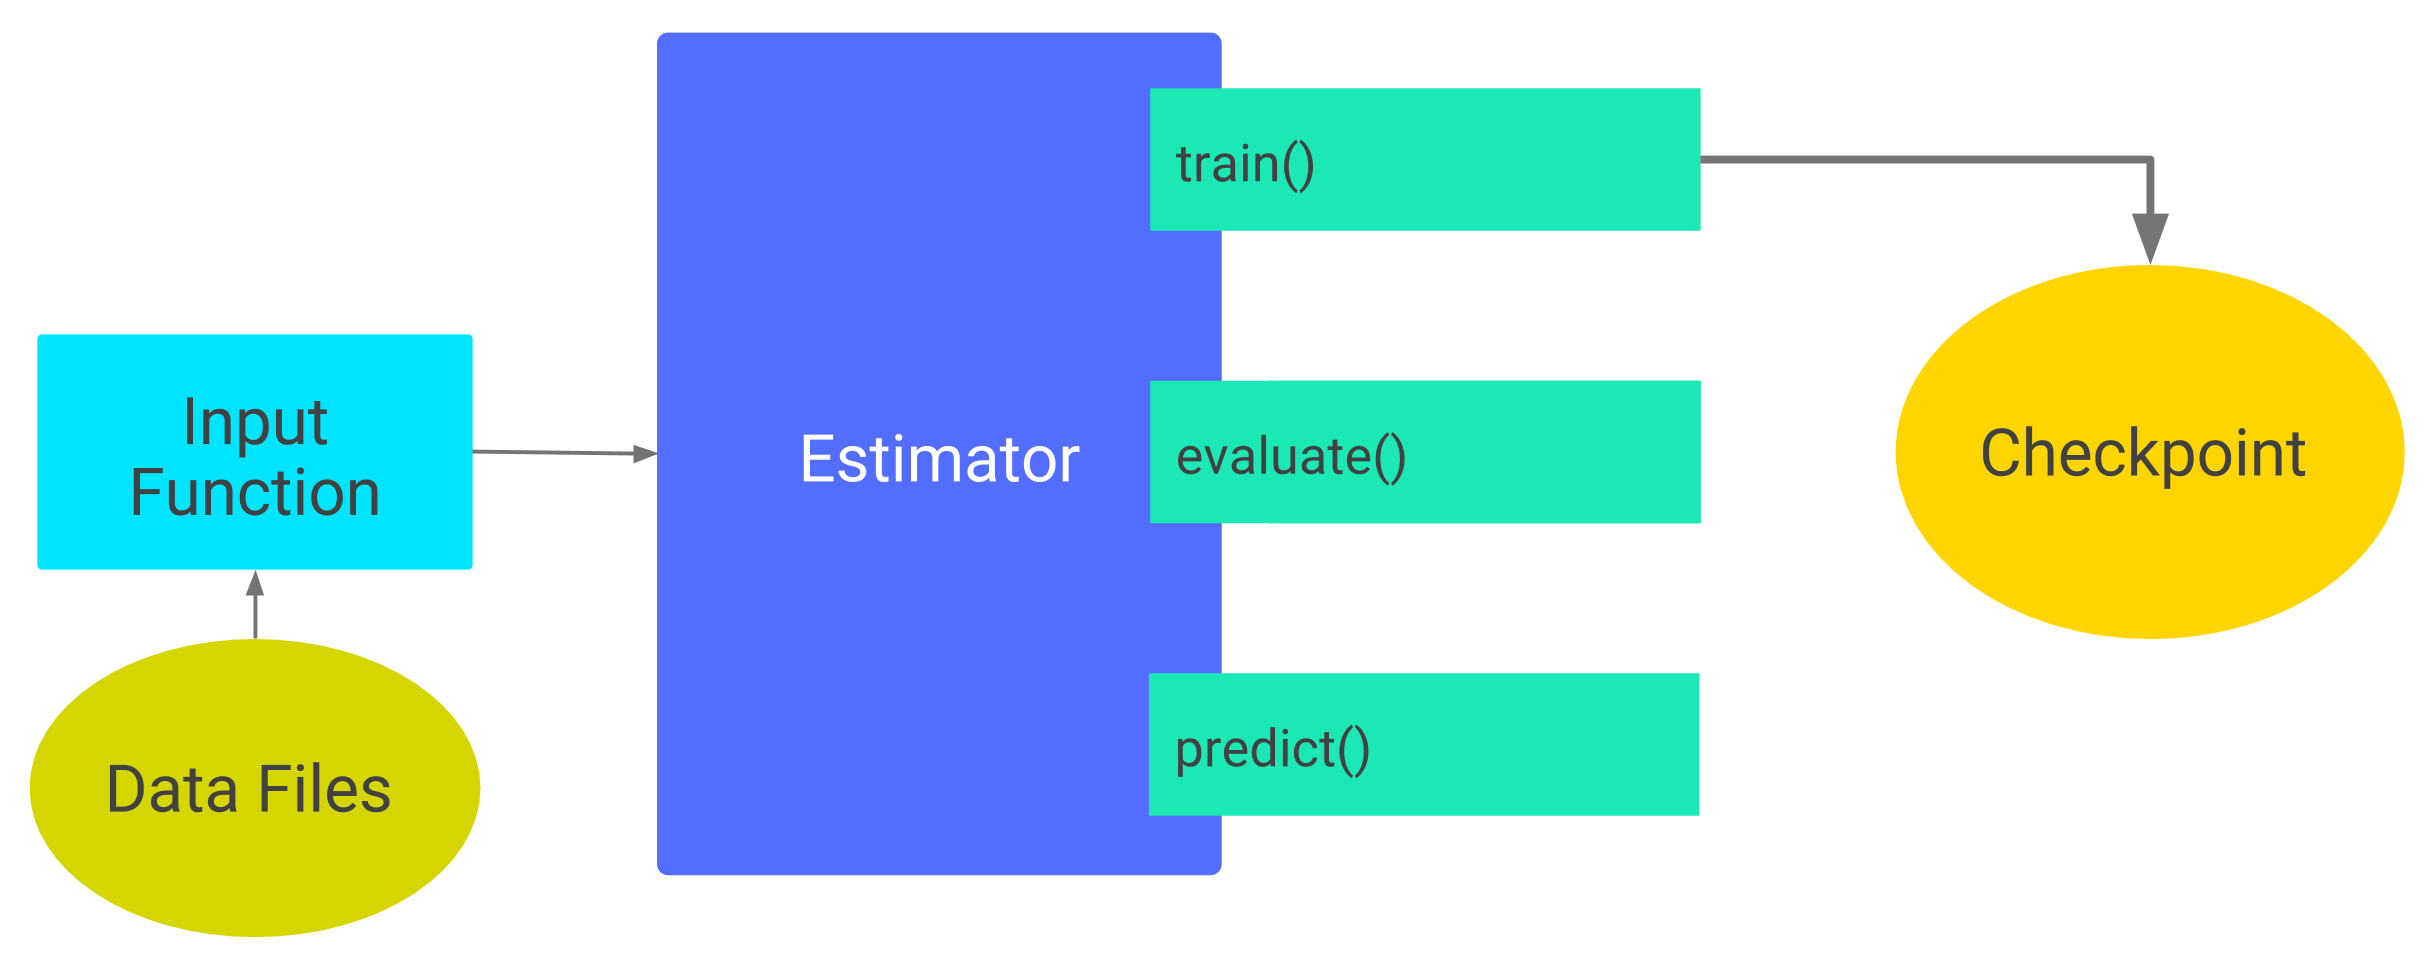

# Setting up ETL pipeline using Estimator API

The tf.estimator.Estimator API merges the first two phases in the implementation of the input_fn function passed to the train and evaluate methods.

The model, and dataset too, can be in a different mode, depending on which phases of the pipeline we are at. The mode is implemented in the enum type tf.estimator.ModeKeys, which contains the three standard keys:

TRAIN: Training mode
EVAL: Evaluation mode
PREDICT: Inference mode

In [0]:
from tensorflow.keras.datasets import fashion_mnist

In [0]:
def get_input_fn(mode, batch_size=32, num_epochs=1):
    (train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
    half = test_x.shape[0] // 2
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_x, input_y = train_x, train_y
        train = True

    elif mode == tf.estimator.ModeKeys.EVAL:
        input_x, input_y = test_x[:half], test_y[:half]
        train = False

    elif mode == tf.estimator.ModeKeys.PREDICT:
        input_x, input_y = test_x[half:-1], test_y[half:-1]
        train = False

    else:
        raise ValueError("tf.estimator.ModeKeys Invalid")
    
    def scale_fn(image, label):
        return ((tf.image.convert_image_dtype(image, tf.float32) - 0.5) * 2.0, tf.cast(label, tf.int32))
    
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(input_x, -1), tf.expand_dims(input_y, -1))).map(scale_fn)

        if train:
            dataset = dataset.shuffle(10).repeat(num_epochs)
        
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

    return input_fn


# Custom Estimators

Premade and custom estimators share a common architecture: both aim to build a tf.estimator.EstimatorSpec object that fully defines the model to be run by tf.estimator.Estimator; the return value of any model_fn is, therefore, the Estimator specification.

The model_fn function follows this signature:

model_fn(
    features,
    labels,
    mode = None,
    params = None,
    config = None
)
The function parameters are:

- features is the first item returned from input_fn
- labels is the second item returned from input_fn
- mode is the tf.estimator.ModeKeys object that specifies the status of the model, if it is in the training, evaluation, or prediction phase
params is a dictionary of hyperparameters that can be used to tune the model easily
- config is a tf.estimator.RunConfig object that allows you to configure parameters related to the runtime execution, such as the model parameters directory and the number of distributed nodes to use

Important: The Estimator API, although present in TensorFlow 2.0, still works in graph mode. model_fn, thus, can use Keras to build the model, but the training and summary logging operation must be defined using the tf.compat.v1 compatibility module.

In [0]:
def model_fn(features, labels, mode):
    v1 = tf.compat.v1
    model = make_model(10)
    logits = model(features)

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = tf.argmax(logits, -1)
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    loss = v1.reduce_mean(
        v1.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=v1.squeeze(labels))
    )

    global_step = v1.train.get_global_step()

    # Compute metrics

    accuracy = v1.metrics.accuracy(labels=labels, predictions=v1.argmax(logits, -1), name="accuracy")
    metrics = {"accuracy": accuracy}

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metrics=metrics)
    
    if mode == tf.estimator.ModKeys.TRAIN:
        opt = v1.train.AdamOptimizer(1e-4)
        train_op = opt.minimize(
            loss, var_list = model.trainabl_variables, global_step=global_step
        )

        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

    raise NotImplementedError("Unknown mode ")



In [0]:
print("Every log is on TensorBoard, please run TensorBoard --logidr log") 
estimator = tf.estimator.Estimator(model_fn, model_dir="log") 
epochs = 2
for epoch in range(epochs):
    print("Training epochs number %d "%(epoch))
    estimator.train(get_input_fn(tf.estimator.ModeKeys.TRAIN, num_epochs=1)) 
    print("Evaluating...") 
    estimator.evaluate(get_input_fn(tf.estimator.ModeKeys.EVAL))


# Premade estimators


TensorFlow 2.0 has two different kinds of premade Estimators: the one automatically created from the Keras model definition, and the canned-estimators built upon the TensorFlow 1.x API.

## Keras Estimators

The recommended way of constructing an Estimator object in TensorFlow 2.0 is to use a Keras model itself.

The tf.keras.estimator package offers all the tools required to automatically convert a tf.keras.Model object to its Estimator counterpart.

In [0]:
train_spec = tf.estimator.TrainSpec(input_fn=get_input_fn(tf.estimator.ModeKeys.TRAIN, num_epochs))
eval_spec = tf.estimator.EvalSpec(input_fn=get_input_fn(tf.estimator.ModeKeys.EVAL, num_epochs))

In [0]:
model = make_model(10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
estimator = tf.keras.estimator.model_to_estimator(keras_model=model)

In [0]:
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

## Pinch of Salt

The tf.estimator package comes with a huge list of premade models, ready to use. The full list is available in the documentation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/estimator.

- Unfortunately, the tf.estimator API was added to TensorFlow 2.0 because of the popularity of the Estimator-based solution in 1.x, but this package lacks many features that a Keras-based or pure TensorFlow with eager execution plus AutoGraph offers. 
- When TensorFlow 1.x was the standard, it was tough and time-consuming to experiment with many standard solutions and to manually define several standard computational graphs; that's why the Estimator package gained popularity quickly. 
- Using TensorFlow 2.0 in eager mode and defining models using Keras, instead, allows you to prototype and experiment with many different solutions easily. Moreover, the tf.data API is so flexible that correctly defining the input pipeline is straightforward.

- There is a high chance that in future versions of TensorFlow the, tf.estimator package will be removed or moved to a separate project.